In [21]:
#In case you don't have qiskit, install it now
%pip install qiskit --quiet
#Installing/upgrading pylatexenc seems to have fixed my mpl issue
#If you try this and it doesn't work, try also restarting the runtime/kernel
%pip install pylatexenc --quiet

#Let's go ahead and import all this stuff too
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from qiskit.quantum_info import Statevector
import numpy as np
import random
import math
from qiskit.visualization import plot_histogram, plot_state_qsphere, plot_bloch_multivector, plot_bloch_vector

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
n = 3
num_clauses = 3
aux_num = num_clauses*2 + (num_clauses - 1)
variables = QuantumRegister(n, name='clauses')
auxes = QuantumRegister(aux_num, name='auxes')
U = QuantumCircuit(variables, auxes)
expression = []

for i in range(num_clauses):
    clause = []
    for j in range(3):
        to_add = random.randint(0, n - 1)
        while (to_add in clause):
            to_add = random.randint(0, n - 1)
        clause.append(to_add)
    expression.append(clause)

not_list = []
for i in range(num_clauses * 3):
    not_list.append(random.randint(0,1))

print(expression)
print(not_list)

for i in range(num_clauses):
    first = expression[i][0]
    second = expression[i][1]
    third = expression[i][2]
    first_aux = auxes[2*i]
    second_aux = auxes[2*i + 1]

    if (not not_list[i * 3]):
        U.x(first)
    if (not not_list[1 + i * 3]):
        U.x(second)
    U.x(first_aux)
    U.ccx(first, second, first_aux)
    if (not not_list[i * 3]):
        U.x(first)
    if (not not_list[1 + i * 3]):
        U.x(second)

    U.barrier()

    #or the result of the first two and the third
    U.x(first_aux)
    if (not not_list[2 + i * 3]):
        U.x(third)
    U.x(second_aux)
    U.ccx(first_aux, third, second_aux)
    U.x(first_aux)
    if (not not_list[2 + i * 3]):
        U.x(third)
    U.barrier()
    
if (num_clauses > 1):
    U.ccx(auxes[1], auxes[3], auxes[num_clauses*2])
    for i in range(2, num_clauses):
        U.ccx(auxes[i*2 + 1], auxes[num_clauses*2 + (i - 2)], auxes[num_clauses*2 + (i - 1)])


[[0, 2, 1], [2, 0, 1], [2, 1, 0]]
[0, 1, 1, 1, 0, 1, 0, 1, 0]


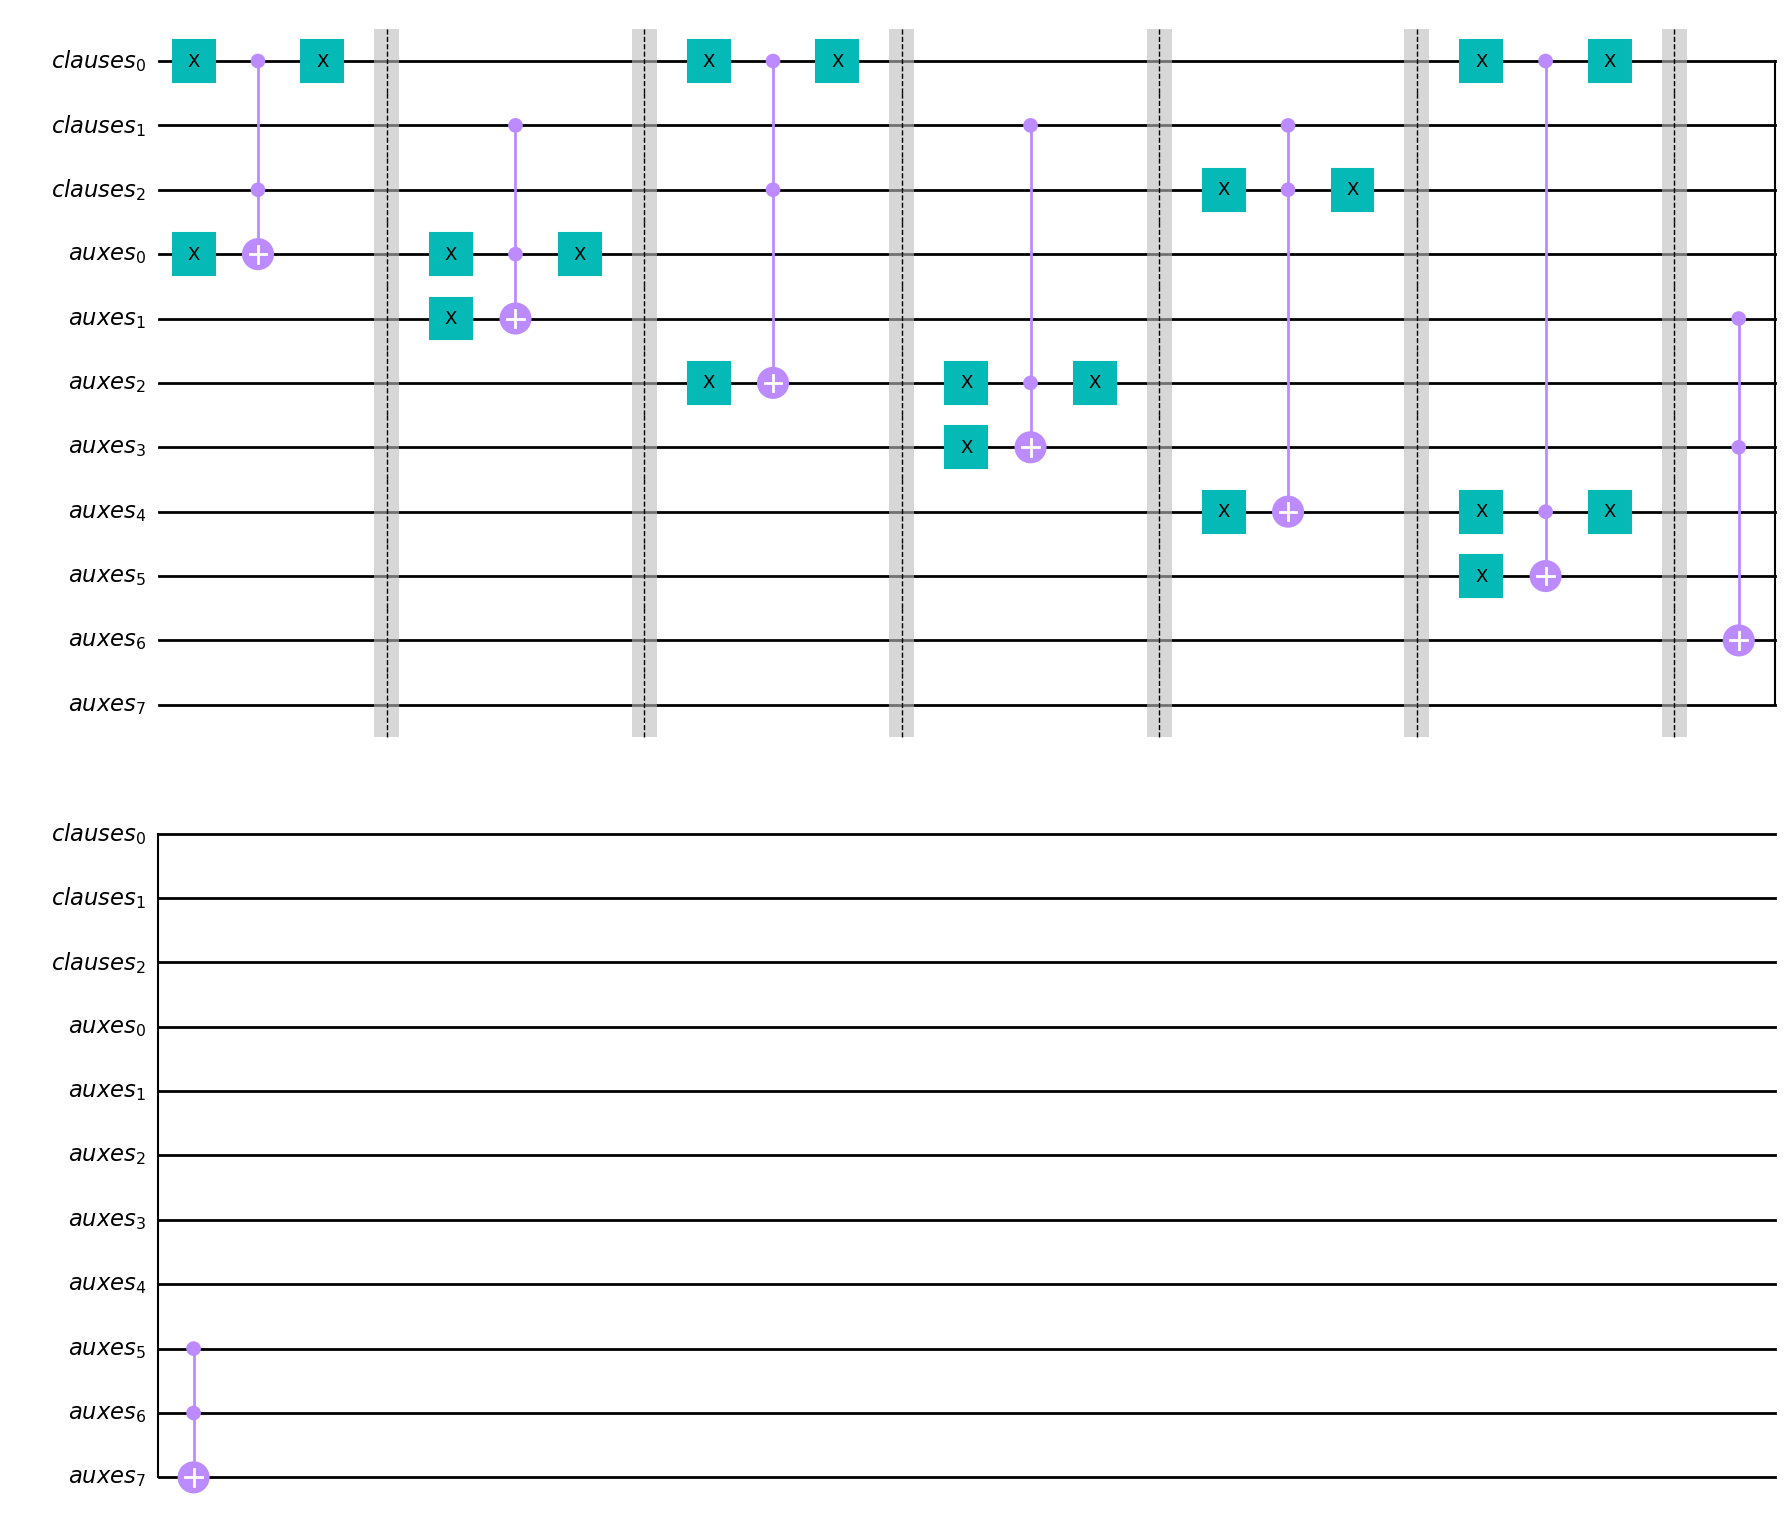

In [23]:
U.draw('mpl', filename='graph.png')


In [24]:
solutions = 0
for i in range(2 ** n):
    vals = []
    for j in range(n):
        vals.append((i >> j) & 1)

    result = 1
    for j in range(num_clauses):
        first = vals[expression[j][0]] ^ not_list[j*3]
        second = vals[expression[j][1]] ^ not_list[j*3 + 1]
        third = vals[expression[j][2]] ^ not_list[j*3 + 2]
        result &= (first | second | third)
    if result:
        solutions += 1
        print(vals)
print(f'num_solutions is {solutions}')
print(not_list)
print(expression)

[0, 0, 0]
[1, 0, 0]
[1, 1, 0]
[0, 0, 1]
[1, 0, 1]
[1, 1, 1]
num_solutions is 6
[0, 1, 1, 1, 0, 1, 0, 1, 0]
[[0, 2, 1], [2, 0, 1], [2, 1, 0]]


0


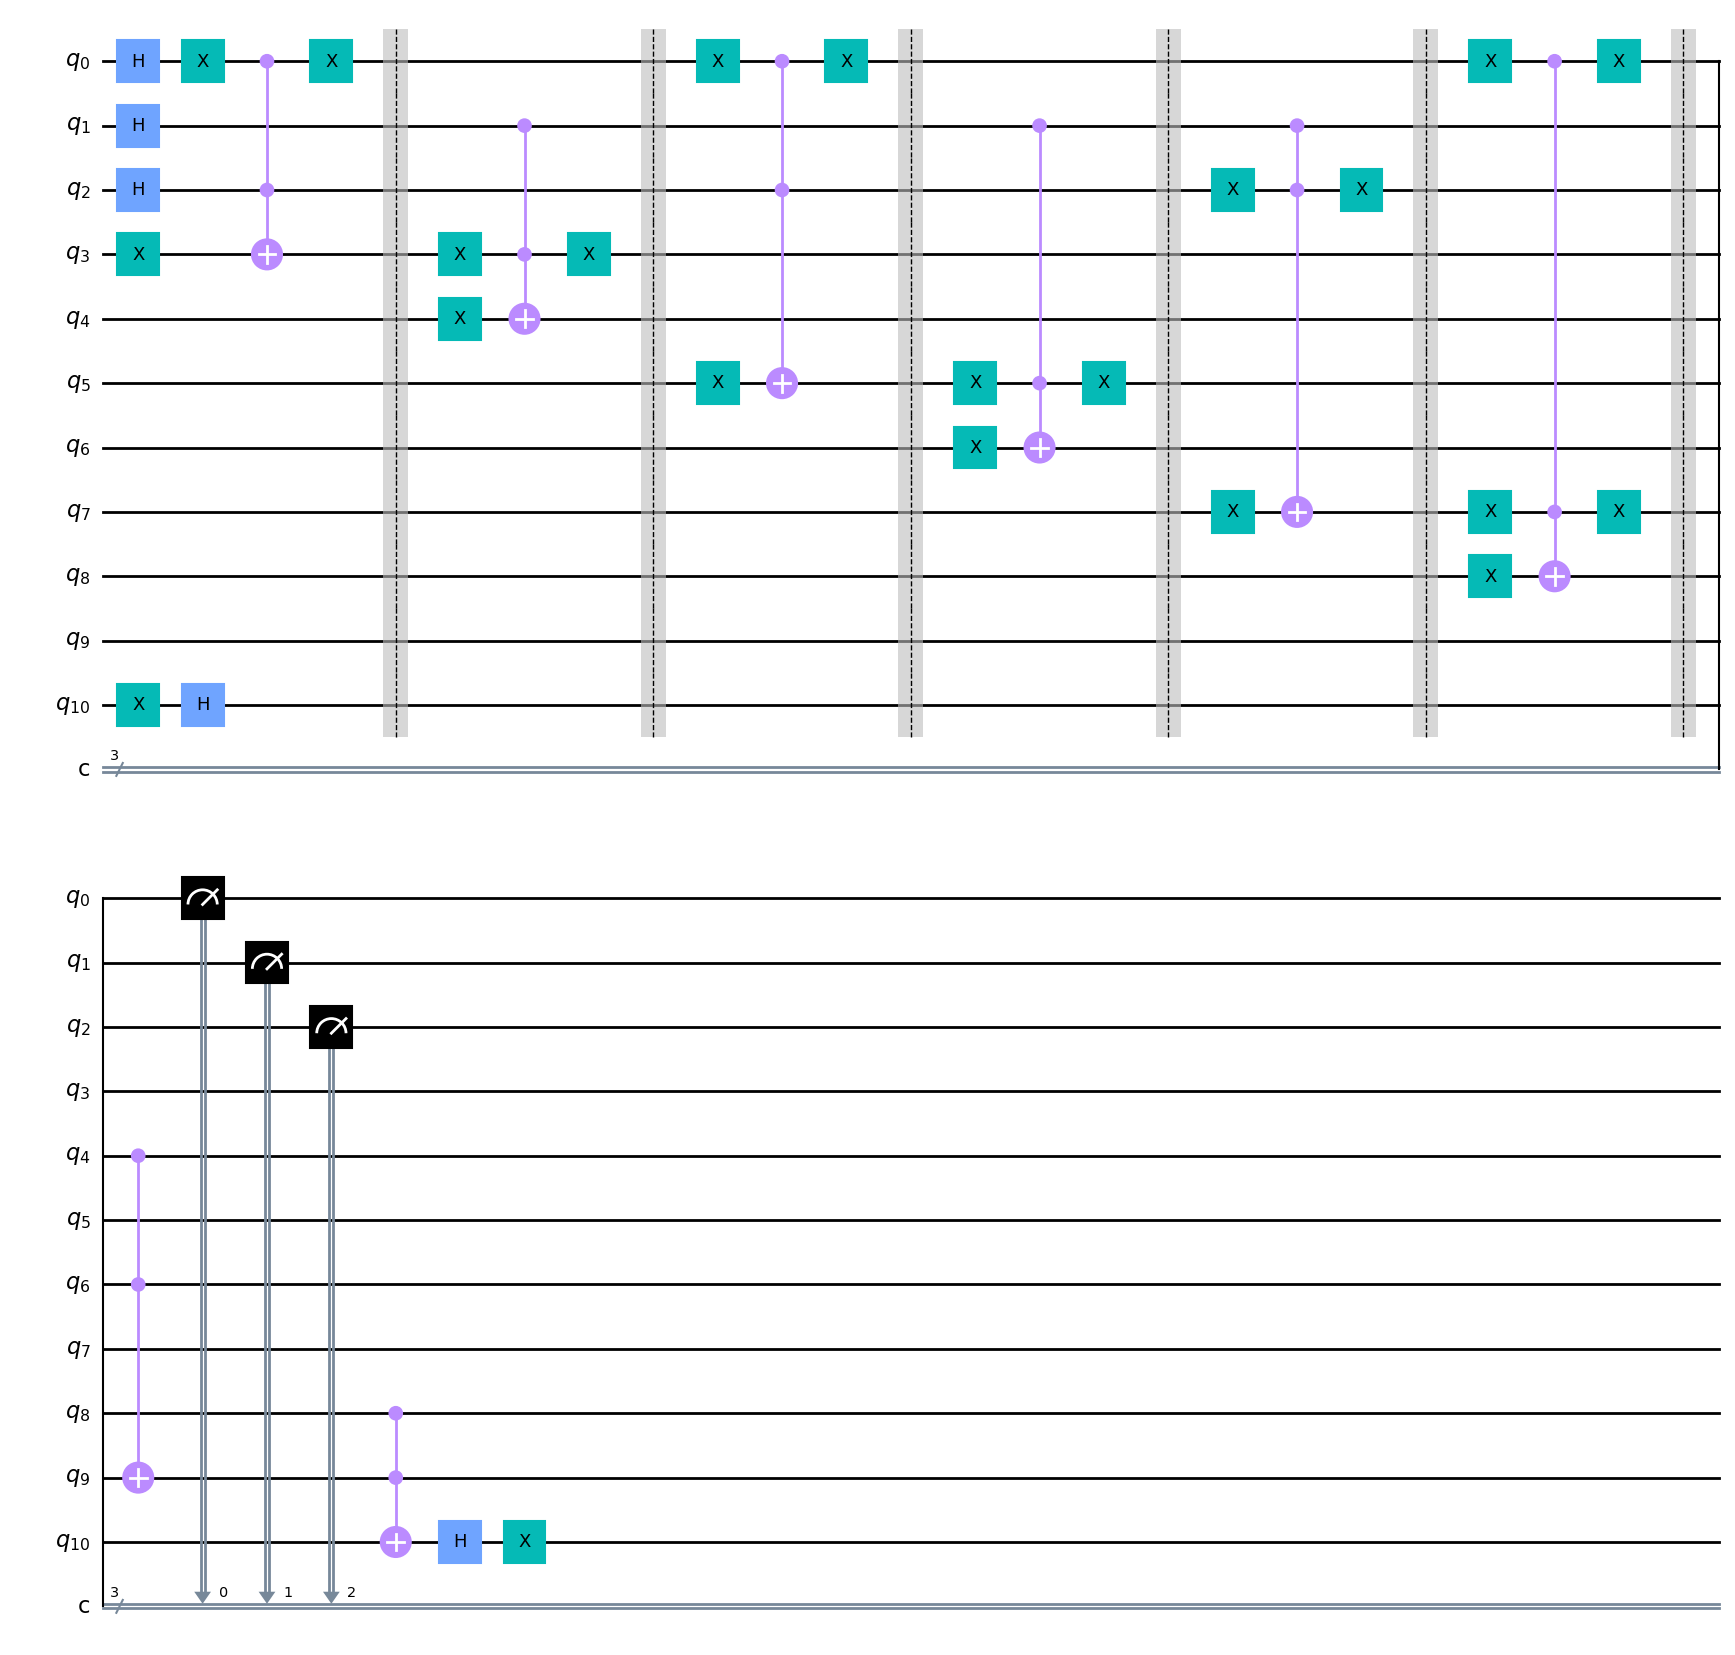

In [25]:
#running grovers
x = QuantumRegister(n, name='x')
auxes = QuantumRegister(aux_num - 1, name='aux')
y = QuantumRegister(1, name='y')
classical = ClassicalRegister(n)
qc = QuantumCircuit(n + aux_num, n)
last = n + aux_num - 1
qc.x(last)
qc.h(last)
qc.h(range(n))

R = math.floor(np.pi * np.sqrt((n ** 2) / solutions) / 4)

print(R)
# test = QuantumCircuit(1,1)
# test.x(0)
# qc.compose(U, inplace=True)

for i in range(R):
    
    qc.compose(U, inplace=True)
    for j in range(0, n):
        qc.h(j)
        qc.x(j)
    qc.h(0)
    qc.mcx(range(1, n), 0)
    qc.h(0)
    for j in range(n):
        qc.x(j)
        qc.h(j)
qc.h(last)
qc.x(last)
qc.measure(range(n), range(n))
qc.draw('mpl')

{'000': 118, '001': 106, '100': 136, '101': 125, '011': 139, '110': 135, '111': 142, '010': 123}


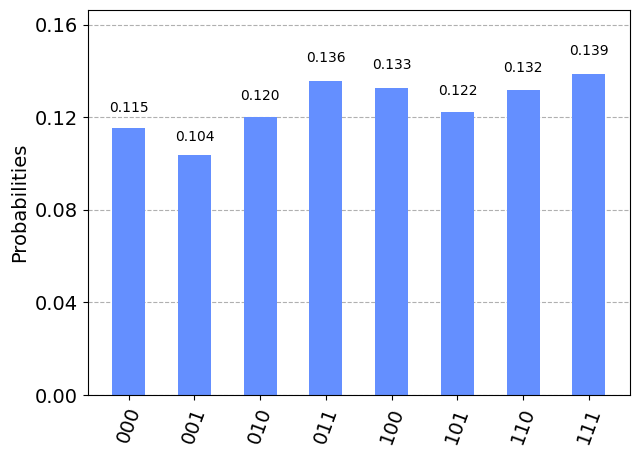

In [26]:
#Simulate your circuit!
backend = Aer.get_backend('qasm_simulator')
counts= execute(qc,backend, shots=1024).result().get_counts(qc)
print(counts)
plot_histogram(counts)